## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import lsdb

from dask.distributed import Client
from io import StringIO
from nested_pandas import NestedDtype, read_parquet
from pathlib import Path

import warnings

# Disable plotting warnings
warnings.filterwarnings("ignore")

In [2]:
lsdb.__version__

'0.6.4'

In [3]:
def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )

In [4]:
pd.set_option('display.max_columns', 100)
# CAT_COLORS = {'2SXPS':'tab:blue', '4XMMDR14':'tab:orange', 'CSC2.1':'tab:green', 'eRASS1':'tab:red', 'XMMSL3':'tab:purple'}
# COLORS = {
#     "u": "#56b4e9",
#     "g": "#009e73",
#     "r": "#f0e442",
#     "i": "#cc79a7",
#     "z": "#d55e00",
#     "y": "#0072b2",
# }

In [5]:
obj = read_parquet('../../data/intermediate_data_products/obj_dp1_xmatch.parquet')
dia = read_parquet('../../data/intermediate_data_products/dia_dp1_xmatch.parquet')

In [6]:
DROPNA = False # reduce photometry while ignoring visits where psfMagErr is Nan

## Get diaObject Mags from diaObjectforcedSource

In [7]:
def get_dia_phot(df, dropna=DROPNA, mean=True):
    FLUX_OR_MAG='Mag'
    flux_or_mag=FLUX_OR_MAG
    results = {}

    if dropna:
        if df is None:
            return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
            
        df = df[~df['psfMagErr'].isna()]
    
    if df is None:
        return {f'{band}_psf{flux_or_mag}':np.nan for band in 'ugrizy'}
        
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_psf{flux_or_mag}'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()
        inv_var = 1 / errors ** 2 

        if mean:
            mean = np.average(fluxes, weights=inv_var)
            results[f'{band}_psf{flux_or_mag}'] = mean
        else:
            med = np.median(fluxes)            
            results[f'{band}_psf{flux_or_mag}'] = med
        
    return results

In [8]:
diaPhot_mean = dia.reduce(get_dia_phot, ('diaObjectForcedSource'))
# diaPhot_med = dia.reduce(get_dia_phot, ('diaObjectForcedSource'), mean=False)

In [9]:
for col in diaPhot_mean.columns:
    dia[col] = diaPhot_mean[col]

## Get StetsonJs

In [10]:
# adapted from https://github.com/lsst/meas_base/blob/e5cf12406b54a6312b9d6fa23fbd132cd7999387/python/lsst/meas/base/diaCalculationPlugins.py#L887

def stetson_mean(values,
                  errors,
                  mean=None,
                  alpha=2.,
                  beta=2.,
                  n_iter=20,
                  tol=1e-6):
    """Compute the stetson mean of the fluxes which down-weights outliers.

    Weighted biased on an error weighted difference scaled by a constant
    (1/``a``) and raised to the power beta. Higher betas more harshly
    penalize outliers and ``a`` sets the number of sigma where a weighted
    difference of 1 occurs.

    Parameters
    ----------
    values : `numpy.dnarray`, (N,)
        Input values to compute the mean of.
    errors : `numpy.ndarray`, (N,)
        Errors on the input values.
    mean : `float`
        Starting mean value or None.
    alpha : `float`
        Scalar down-weighting of the fractional difference. lower->more
        clipping. (Default value is 2.)
    beta : `float`
        Power law slope of the used to down-weight outliers. higher->more
        clipping. (Default value is 2.)
    n_iter : `int`
        Number of iterations of clipping.
    tol : `float`
        Fractional and absolute tolerance goal on the change in the mean
        before exiting early. (Default value is 1e-6)

    Returns
    -------
    mean : `float`
        Weighted stetson mean result.

    References
    ----------
    .. [1] Stetson, P. B., "On the Automatic Determination of Light-Curve
       Parameters for Cepheid Variables", PASP, 108, 851S, 1996
    """
    n_points = len(values)
    n_factor = np.sqrt(n_points / (n_points - 1))
    inv_var = 1 / errors ** 2

    if mean is None:
        mean = np.average(values, weights=inv_var)
    for iter_idx in range(n_iter):
        chi = np.fabs(n_factor * (values - mean) / errors)
        tmp_mean = np.average(
            values,
            weights=inv_var / (1 + (chi / alpha) ** beta))
        diff = np.fabs(tmp_mean - mean)
        mean = tmp_mean
        if diff / mean < tol and diff < tol:
            break
    return mean
    
def _stetson_J(fluxes, errors, mean=None):
        """Compute the single band stetsonJ statistic.

        Parameters
        ----------
        fluxes : `numpy.ndarray` (N,)
            Calibrated lightcurve flux values.
        errors : `numpy.ndarray` (N,)
            Errors on the calibrated lightcurve fluxes.
        mean : `float`
            Starting mean from previous plugin.

        Returns
        -------
        stetsonJ : `float`
            stetsonJ statistic for the input fluxes and errors.

        References
        ----------
        .. [1] Stetson, P. B., "On the Automatic Determination of Light-Curve
           Parameters for Cepheid Variables", PASP, 108, 851S, 1996
        """
        n_points = len(fluxes)
        flux_mean = stetson_mean(fluxes, errors, mean)
        delta_val = (
            np.sqrt(n_points / (n_points - 1)) * (fluxes - flux_mean) / errors)
        p_k = delta_val ** 2 - 1

        return np.mean(np.sign(p_k) * np.sqrt(np.fabs(p_k)))
    
def rubin_stetsonJ(df, dropna=DROPNA):
    results = {}
    flux_or_mag = 'Flux'

    if dropna:
        if df is None:
            return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
            
        df = df[~df['psfMagErr'].isna()]
        
    if df is None:
        return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 2:
            results[f'{band}_psfFluxForcedStetsonJ'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()

        results[f'{band}_psfFluxForcedStetsonJ'] = _stetson_J(
            fluxes,
            errors)
    return results





In [11]:
objJs = obj.reduce(rubin_stetsonJ, ("objectForcedSource"))
diaJs = dia.reduce(rubin_stetsonJ, ("diaObjectForcedSource"))

for col in diaJs.columns:
    dia[col] = diaJs[col]

for col in objJs.columns:
    obj[col] = objJs[col]

In [12]:
obj_random = read_parquet('../../data/intermediate_data_products/obj_dp1_xmatch_random.parquet')
randomJs = obj_random.reduce(rubin_stetsonJ, ("objectForcedSource"))

for col in randomJs.columns:
    obj_random[col] = randomJs[col]

### Get number of obs in forcedPhotometry

Could use this later to combine Stetson Js across all bands for each object (take the mean weighted by n_obs)

In [13]:
def nForced(df, dropna=DROPNA):
    results = {}
    flux_or_mag = 'Mag'
    if dropna:
        if df is None:
            return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
        df = df[~df['psfMagErr'].isna()]
            
    if df is None:
        return {f'{band}_nForced':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_nForced'] = int(0)
            continue

        results[f'{band}_nForced'] = int(len(tmpDf))
        
    return results

In [14]:
objNs = obj.reduce(nForced, ("objectForcedSource"))

diaNs = dia.reduce(nForced, ("diaObjectForcedSource"))

for col in diaNs.columns:
    dia[col] = diaNs[col]

for col in objNs.columns:
    obj[col] = objNs[col]

## Get optical fluxes in erg/s/cm**2

In [15]:
def combine_nJy_flux(df, suffix='_psfFlux'):
    """
    Combine LSST filter fluxes in nanojanskys into total flux in erg/s/cm^2,
    using Astropy for unit handling.

    Returns:
        total_flux (Quantity): Combined flux in erg/s/cm^2 (Astropy Quantity)
    """

    # LSST central wavelengths and bandwidths in nm
    filters = {
        'u': (367, 40),
        'g': (482, 137),
        'r': (622, 132),
        'i': (754, 127),
        'z': (869, 118),
        'y': (971, 65),
    }

    total_flux = 0.0 * u.erg / u.s / u.cm**2
    from astropy.constants import c


    for band in 'ugrizy':
        # try: 
            f_nJy = df[band+suffix]
            if pd.isna(f_nJy):
                f_nJy = 0.0 * u.nJy
            else:
                f_nJy = f_nJy * u.nJy
            lambda_eff_nm, delta_lambda_nm = filters[band]
    
            lambda_eff = lambda_eff_nm * u.nm
            delta_lambda = delta_lambda_nm * u.nm
    
            # Convert wavelength to frequency bandwidth using Δν = c * Δλ / λ^2
            delta_nu = (c * delta_lambda / lambda_eff**2).to(u.Hz)
    
            # Convert nJy to erg/s/cm^2/Hz
            f_nu = f_nJy.to(u.erg / u.s / u.cm**2 / u.Hz)
            
            # Total flux in this band: F = f_nu × Δν
            flux_band = f_nu * delta_nu
    
            total_flux += flux_band
        # except:
        #     import pdb; pdb.set_trace()

    return total_flux

In [16]:
F_opt = []
for _, row in obj.iterrows():
    F_opt.append(combine_nJy_flux(row).to(u.erg / u.s / u.cm**2))
F_opt = [x.value for x in F_opt]

obj['F_opt'] = F_opt

In [17]:
def get_dia_phot(df, dropna=DROPNA):
    flux_or_mag='Flux'
    results = {}

    if dropna:
        if df is None:
            return {f'{band}_psfFluxForcedStetsonJ':np.nan for band in 'ugrizy'}
        df = df[~df['psfMagErr'].isna()]
    
    if df is None:
        return {f'{band}_psf{flux_or_mag}':np.nan for band in 'ugrizy'}
    for band in 'ugrizy':
        tmpDf = df[df['band'] == band]
        tmpDf = tmpDf[~np.logical_or(np.isnan(tmpDf[f"psf{flux_or_mag}"]),
                                  np.isnan(tmpDf[f"psf{flux_or_mag}Err"]))]
        
        if len(tmpDf) < 1:
            results[f'{band}_psf{flux_or_mag}'] = np.nan
            continue

        fluxes = tmpDf[f"psf{flux_or_mag}"].to_numpy()
        errors = tmpDf[f"psf{flux_or_mag}Err"].to_numpy()
        inv_var = 1 / errors ** 2

        mean = np.average(fluxes, weights=inv_var)
        results[f'{band}_psf{flux_or_mag}'] = mean
        
    return results

diaPhot_flux = dia.reduce(get_dia_phot, ('diaObjectForcedSource'))

In [18]:
F_opt_dia = []
for _, row in diaPhot_flux.iterrows():
    F_opt_dia.append(combine_nJy_flux(row).to(u.erg / u.s / u.cm**2))
F_opt_dia = [x.value for x in F_opt_dia]

dia['F_opt'] = F_opt_dia

### plots

In [19]:
CAT_COLORS = {'2SXPS':'tab:blue', '4XMMDR14':'tab:orange', 'CSC2.1':'tab:green', 'eRASS1':'tab:red', 'XMMSL3':'tab:purple'}
FIELDS = ['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']
# FIELD_COLORS = {'47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25'}
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

In [20]:
# # Plot points with colors based on catalog
# for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
#     mask = np.array(obj['cat_X']) == cat
#     plt.scatter(np.log10(obj['F_X'][mask]), np.log10(obj['F_X'][mask])-np.log10(obj['F_opt'][mask]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# # Labels and title
# plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
# plt.ylabel('$log(F_X/F_{opt})$')

# plt.title("X-ray to Optical Flux Ratio")

# # Legend
# plt.legend()

# # plt.savefig('plots/Fx_to_Fopt.png')
# # Show plot
# plt.show()

In [21]:
# # Plot points with colors based on catalog
# for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
#     mask = np.array(dia['cat_X']) == cat
#     plt.scatter(np.log10(dia['F_X'][mask]), np.log10(dia['F_X'][mask])-np.log10(dia['F_opt'][mask]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# # Labels and title
# plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
# plt.ylabel('$log(F_X/F_{opt})$')

# plt.title("X-ray to Optical Flux Ratio - diaObjects")

# # Legend
# plt.legend()

# # plt.savefig('plots/Fx_to_Fopt.png')
# # Show plot
# plt.show()

In [22]:
# # Plot points with colors based on catalog
# for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
#     mask = np.array(obj['cat_X']) == cat
#     mask_dia = np.array(dia['cat_X']) == cat
#     plt.scatter(np.log10(obj['F_X'][mask]), np.log10(obj['F_X'][mask])-np.log10(obj['F_opt'][mask]), marker='.', label=cat, alpha=0.3, s=8, color='silver')
#     plt.scatter(np.log10(dia['F_X'][mask_dia]), np.log10(dia['F_X'][mask_dia])-np.log10(dia['F_opt'][mask_dia]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# # Labels and title
# plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
# plt.ylabel('$log(F_X/F_{opt})$')

# plt.title("X-ray to Optical Flux Ratio")

# # Legend
# # plt.legend()

# # plt.savefig('plots/Fx_to_Fopt.png')
# # Show plot
# plt.show()

In [23]:
# plt.figure()
# for band in 'grizy':
#     col = f'{band}_psfFluxForcedStetsonJ'
#     plt.hist(obj[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
#     plt.xscale('log')
# plt.legend()
# plt.xlabel('StetsonJ')
# plt.title('StetsonJ on forced phot on objects')

# plt.figure()
# for band in 'grizy':
#     col = f'{band}_psfFluxForcedStetsonJ'
#     plt.hist(dia[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
#     plt.xscale('log')
# plt.legend()
# plt.title('StetsonJ on forced phot on diaObjects')
# plt.xlabel('StetsonJ')

In [24]:
# plt.figure()
# for band in 'ugrizy':
#     plt.hist(dia[f'{band}_psfFluxStetsonJ'], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
#     plt.xscale('log')
# plt.legend()
# plt.title('StetsonJ on diaSources')
# plt.xlabel('StetsonJ')

Text(0.5, 1.0, 'StetsonJ on forced phot on objects')

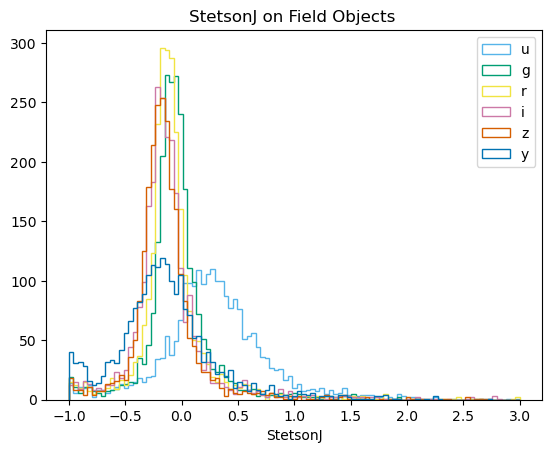

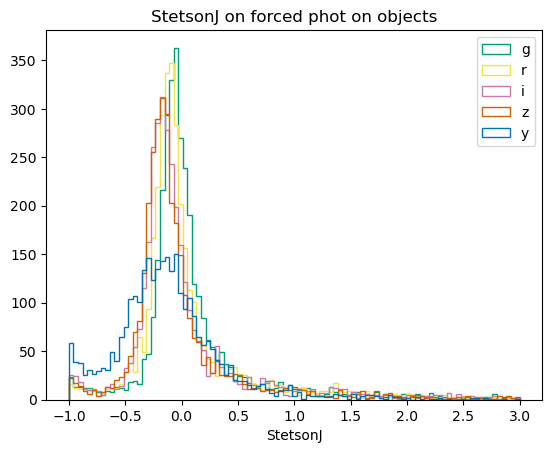

In [25]:
plt.figure()
for band in 'ugrizy':
    plt.hist(obj_random[f'{band}_psfFluxForcedStetsonJ'], bins=np.linspace(-1, 3, 100), histtype='step', color=COLORS[band], label=band)
    # plt.xscale('log')

plt.legend()
plt.title('StetsonJ on Field Objects ')
plt.xlabel('StetsonJ')

plt.figure()
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(obj[col], bins=np.linspace(-1, 3, 100), histtype='step', color=COLORS[band], label=band)
    # plt.xscale('log')
plt.legend()
plt.xlabel('StetsonJ')
plt.title('StetsonJ on forced phot on objects')


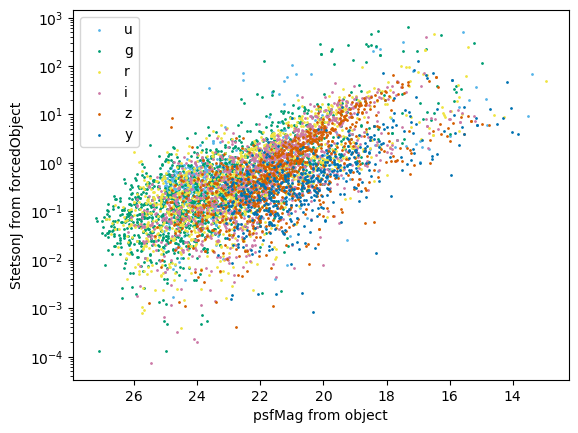

In [26]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    sub = obj[(obj[f"{band}_psfFlux"] / obj[f"{band}_psfFluxErr"]) > 5]
    plt.scatter(sub[f"{band}_psfMag"], sub[col], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from object')
plt.ylabel('StetsonJ from forcedObject')
plt.legend()

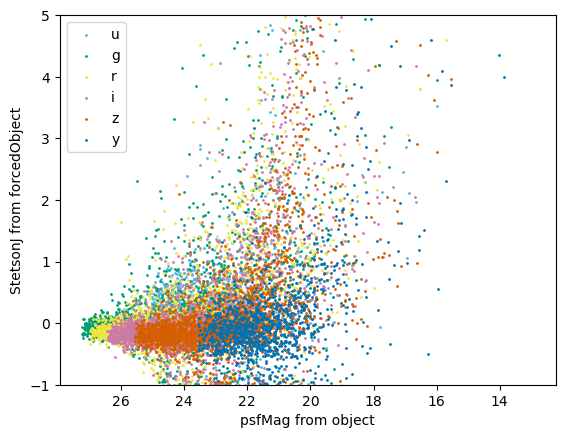

In [27]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    sub = obj[(obj[f"{band}_psfFlux"] / obj[f"{band}_psfFluxErr"]) > 5]
    plt.scatter(sub[f"{band}_psfMag"], sub[col], color=COLORS[band], label=band, s=1)
    # plt.yscale('log')
plt.ylim([-1, 5])
plt.gca().invert_xaxis()
plt.xlabel('psfMag from object')
plt.ylabel('StetsonJ from forcedObject')
plt.legend()

### Save to parquet

In [28]:
if DROPNA:
    dia.to_parquet('../../data/final_data_products/dia_dp1_xmatch_added_real_psfMagErr.parquet')
    obj.to_parquet('../../data/final_data_products/obj_dp1_xmatch_added_real_psfMagErr.parquet')
else:
    dia.to_parquet('../../data/final_data_products/dia_dp1_xmatch_added.parquet')
    obj.to_parquet('../../data/final_data_products/obj_dp1_xmatch_added.parquet')

## Combine dia, obj

In [29]:
if DROPNA:
    obj = read_parquet('../../data/final_data_products/obj_dp1_xmatch_added_real_psfMagErr.parquet')
    dia = read_parquet('../../data/final_data_products/dia_dp1_xmatch_added_real_psfMagErr.parquet')
else:
    obj = read_parquet('../../data/final_data_products/obj_dp1_xmatch_added.parquet')
    dia = read_parquet('../../data/final_data_products/dia_dp1_xmatch_added.parquet')


In [30]:
sub_obj = obj[['coord_ra', 'coord_dec', 'objectId', 'r_psfMag', 'F_opt']].rename({'coord_ra':'ra', 'coord_dec':'dec'}, axis=1)
sub_dia = dia[['ra', 'dec', 'diaObjectId', 'r_psfMag', 'F_opt']]

In [31]:
sub_obj = lsdb.from_dataframe(sub_obj)
sub_dia = lsdb.from_dataframe(sub_dia)

In [32]:
both = sub_obj.crossmatch(sub_dia, suffixes=["", "_dia"]).compute()

<Axes: >

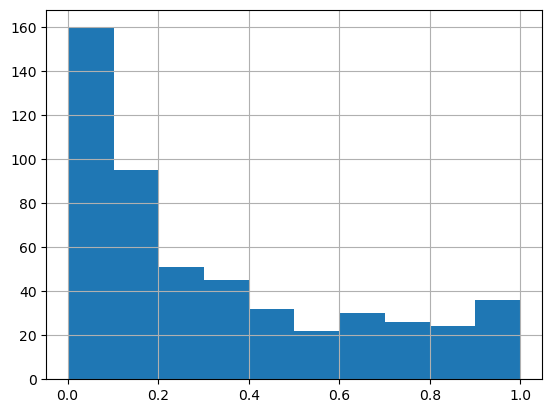

In [33]:
both['_dist_arcsec'].hist()

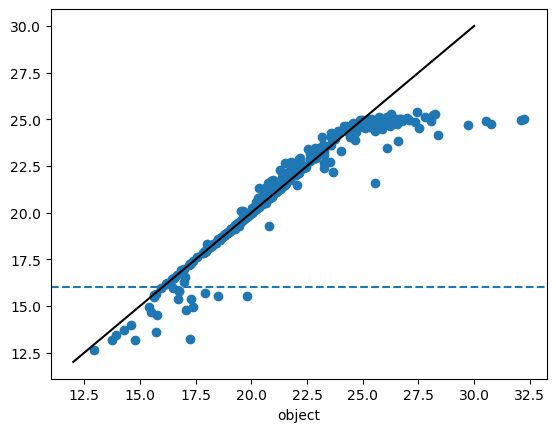

In [34]:
plt.scatter(both['r_psfMag'], both['r_psfMag_dia'])
plt.axhline(16, ls='--')
plt.xlabel('object')
plt.plot([12, 30], [12, 30], color='k')

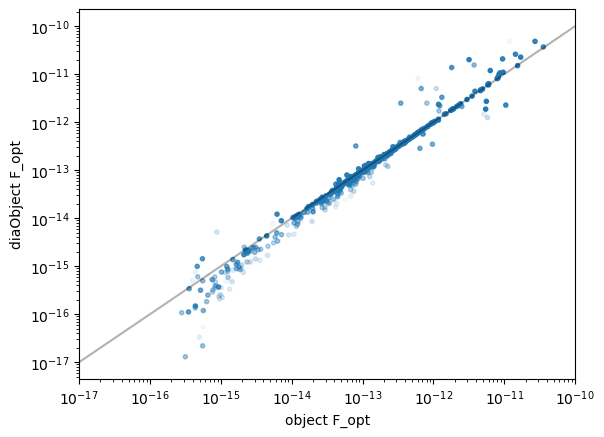

In [35]:
plt.plot([1e-17, 1e-10], [1e-17, 1e-10], color='k', alpha=.3)
plt.scatter(both['F_opt'], both['F_opt_dia'], alpha=1-both['_dist_arcsec'], marker='.')
# plt.scatter(both_NA['F_opt'], both_NA['F_opt_dia'], alpha=both_NA['_dist_arcsec'], marker='.', label='no dropping')
# plt.axhline(16, ls='--')
plt.xlabel('object F_opt')
plt.ylabel('diaObject F_opt')
plt.xlim([1e-17, 1e-10])
plt.xscale('log')
plt.yscale('log')
# plt.legend()

In [36]:
both.rename({'diaObjectId_dia':'diaObjectId'}, axis=1, inplace=True)

In [37]:
if DROPNA:
    both.to_csv('../../data/final_data_products/obj_x_dia_real_psfMagErr.csv', index=False)
else:
    both.to_csv('../../data/final_data_products/obj_x_dia.csv', index=False)

# Calculate reliability and False alarm probability

## Find densities

In [38]:
from upath import UPath

base_path = UPath("/rubin/lsdb_data")
df_X = pd.read_csv('../../data/final_data_products/xray_in_DP1.csv')
# obj_catalog = lsdb.open_catalog('/epyc/data3/hats/catalogs/dp1/object_collection/object_lc', columns=['coord_ra', 'coord_dec'])
obj_catalog = lsdb.open_catalog(base_path / "object_collection/object_lc", columns=['coord_ra', 'coord_dec'])
# obj_catalog = obj_catalog.map_partitions(cast_nested, columns=["objectForcedSource"])

#### run cell below for rsp

In [39]:
df_X = pd.read_csv('../../data/final_data_products/xray_in_DP1.csv')

from upath import UPath

base_path = UPath("/rubin/lsdb_data")
obj_catalog = lsdb.open_catalog(base_path / "object_collection/object_lc", columns=['coord_ra', 'coord_dec'])


### Count number of sources in annulus around each x-ray object
inner radius: 4sig \
outer radius: 8sig (+10 arcsec if no sources in annulus)  
**This can take a long time** so I've uploaded the calculated densities in the intermediate_data_products directory

In [40]:
# ns_inner = []
# ns_outer = []
# rs_outer = []
# for i, row in df_X.iterrows():
#     # outer radius of annulus set to 8sig
#     r_outer = max(8*row.e_pos_1sig, 20)
#     r_inner = 4*row.e_pos_1sig

#     if r_outer < r_inner:
#         import pdb
#         pdb.set_trace()

#     # print number of counts calculated
#     if (i % 100) == 0:
#         print(f"{i} / {len(df_X)}")

#     # get number of objects in inner and outer circle
#     n_outer = len(obj_catalog.cone_search(ra=row.ra, dec=row.dec, radius_arcsec=r_outer).compute())
#     n_inner = len(obj_catalog.cone_search(ra=row.ra, dec=row.dec, radius_arcsec=r_inner).compute())

#     # if the number in the annulus is the same, increase outer radius by 10" at a time
#     while (n_outer - n_inner) < 2: # make sure at least two sources in annulus
#         r_outer += 10

#         # recalculate the number of objects within the outer radius after increasing in size
#         n_outer = len(obj_catalog.cone_search(ra=row.ra, dec=row.dec, radius_arcsec=r_outer).compute())

#     ns_inner.append(n_inner)
#     ns_outer.append(n_outer)
#     rs_outer.append(r_outer)
        
# df_X['n_obj_inner'] = ns_inner
# df_X['n_obj_outer'] = ns_outer       
# df_X['r_inner'] = df_X['e_pos_1sig'] * 4
# df_X['r_outer'] = rs_outer
# # df_X.to_csv('../../data/intermediate_data_products/xray_in_DP1_densities.csv', index=False)

### check that xray objects with dp1 Object matches have n_inner >= 1

In [41]:
# df_X = pd.read_csv('../../data/intermediate_data_products/xray_in_DP1_densities.csv')

In [42]:
# df_X[df_X['obj_flag']]['n_obj_inner'].value_counts().sort_index()

### Get densities

In [43]:
# from astropy.coordinates import Angle
# import astropy.units as u
# import numpy as np

# def spherical_cap_area_sqdeg(radius_arcsec, unit=u.arcsec**2):
#     """
#     Compute the area of a circular region on the celestial sphere
#     with a given radius (in arcseconds), in square degrees.

#     Parameters:
#     - radius_arcsec: Angular radius in arcseconds
#     - unit: astropy unit of the area (either u.arcsec**2 or u.degree**2)

#     Returns:
#     - Area in square degrees
#     """
#     theta = Angle(radius_arcsec, unit=u.arcsec).radian
#     area_steradian = 2 * np.pi * (1 - np.cos(theta))
#     area_sqdeg = area_steradian * (180/np.pi)**2 * u.degree **2
#     return area_sqdeg.to(unit).value

##### check

In [44]:
# spherical_cap_area_sqdeg(3600, unit=u.degree**2)

In [45]:
# inner_asec2 = []
# outer_asec2 = []
# inner_deg2 = []
# outer_deg2 = []
# for i, row in df_X.iterrows():
#     inner_deg2.append(spherical_cap_area_sqdeg(row.r_inner, unit=u.degree**2))
#     outer_deg2.append(spherical_cap_area_sqdeg(row.r_outer, unit=u.degree**2))
#     inner_asec2.append(spherical_cap_area_sqdeg(row.r_inner, unit=u.arcsec**2))
#     outer_asec2.append(spherical_cap_area_sqdeg(row.r_outer, unit=u.arcsec**2))
# df_X['area_inner_asec2'] = inner_asec2
# df_X['area_outer_asec2'] = outer_asec2
# df_X['area_inner_deg2'] = inner_deg2
# df_X['area_outer_deg2'] = outer_deg2

In [46]:
# df_X['N_deg2'] = (df_X['n_obj_outer'] - df_X['n_obj_inner']) / (df_X['area_outer_deg2'] - df_X['area_inner_deg2'])
# df_X['N_asec2'] = (df_X['n_obj_outer'] - df_X['n_obj_inner']) / (df_X['area_outer_asec2'] - df_X['area_inner_asec2'])

### Plot residuals between annulus number density and density within outer circle

We expect many residuals centered at zero, but also a slight bump in negative direction, because the annulus number density, which excludes the counterpart, should be lower than the total density in the circle

In [47]:
# resids = df_X['N_asec2'] - (df_X['n_obj_outer'] / df_X['area_outer_asec2'])

# resids.hist(bins=100)

In [48]:
# df_X.to_csv('../../data/intermediate_data_products/xray_in_DP1_densities.csv', index=False)

# Calculate reliability of crossmatch and false alarm probability

In [49]:
obj = read_parquet('../../data/final_data_products/obj_dp1_xmatch_added.parquet')
df_X = pd.read_csv('../../data/intermediate_data_products/xray_in_DP1_densities.csv')

In [50]:
obj['norm_dist'] = obj['_dist_arcsec'] / obj['e_pos_1sig_X']


In [51]:
obj['reliability'] = [np.exp(-np.pi * row._dist_arcsec ** 2 * df_X.query(f'name == "{row.name_X}"')['N_asec2'].iloc[0]) for i,row in obj.iterrows()]

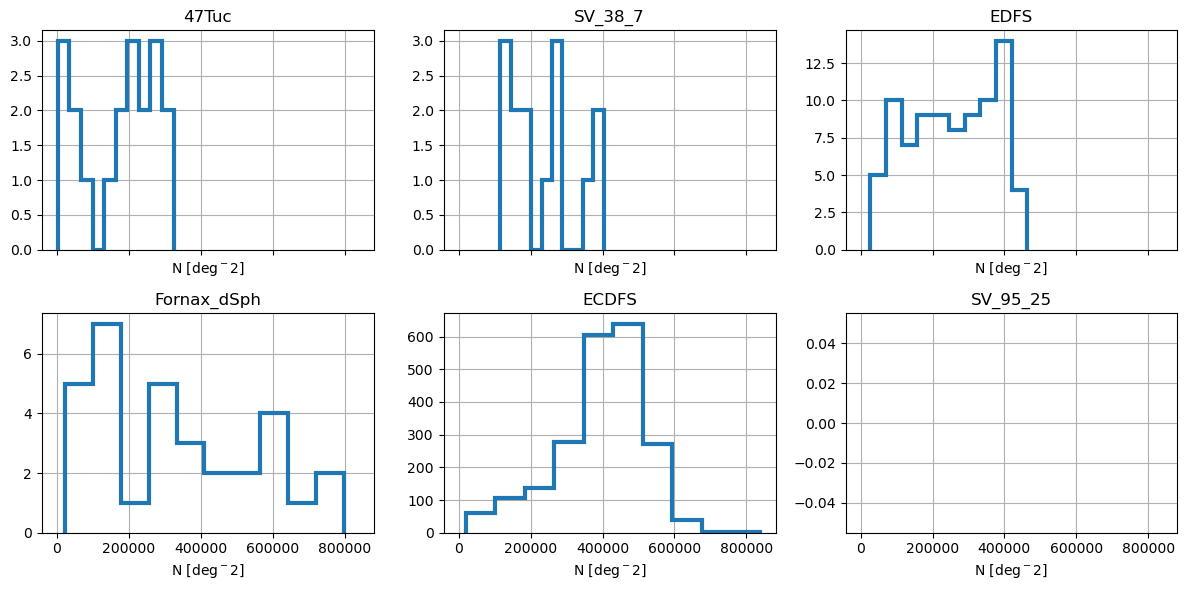

In [52]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(12,6))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    row = i%2
    col = i%3
    sub = df_X[df_X['obj_flag']].query(f'field == "{field}"')['N_deg2']
    sub.hist(ax=axs[row,col], histtype='step', linewidth=3)
    axs[row,col].set_title(field)
    axs[row,col].set_xlabel(r'N [deg$^-2$]')
plt.tight_layout()

### Plot reliability of closest counterpart

In [53]:
obj_closest = obj.sort_values('norm_dist', ascending=True).drop_duplicates('name_X', keep='first')

In [54]:
len(obj_closest)

2314

Text(0.5, 0, 'Reliability of closest counterpart')

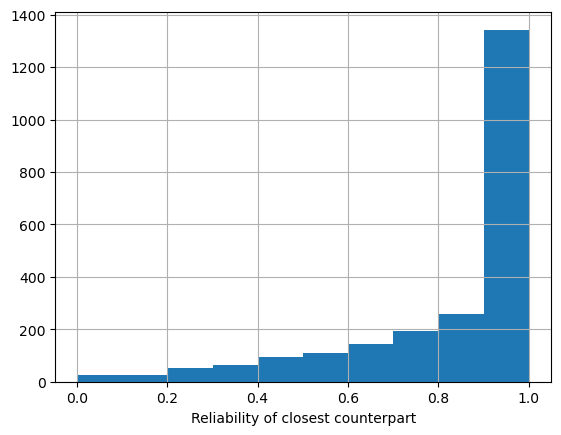

In [55]:
fig, ax = plt.subplots()
obj_closest['reliability'].hist(ax=ax)
plt.xlabel('Reliability of closest counterpart')

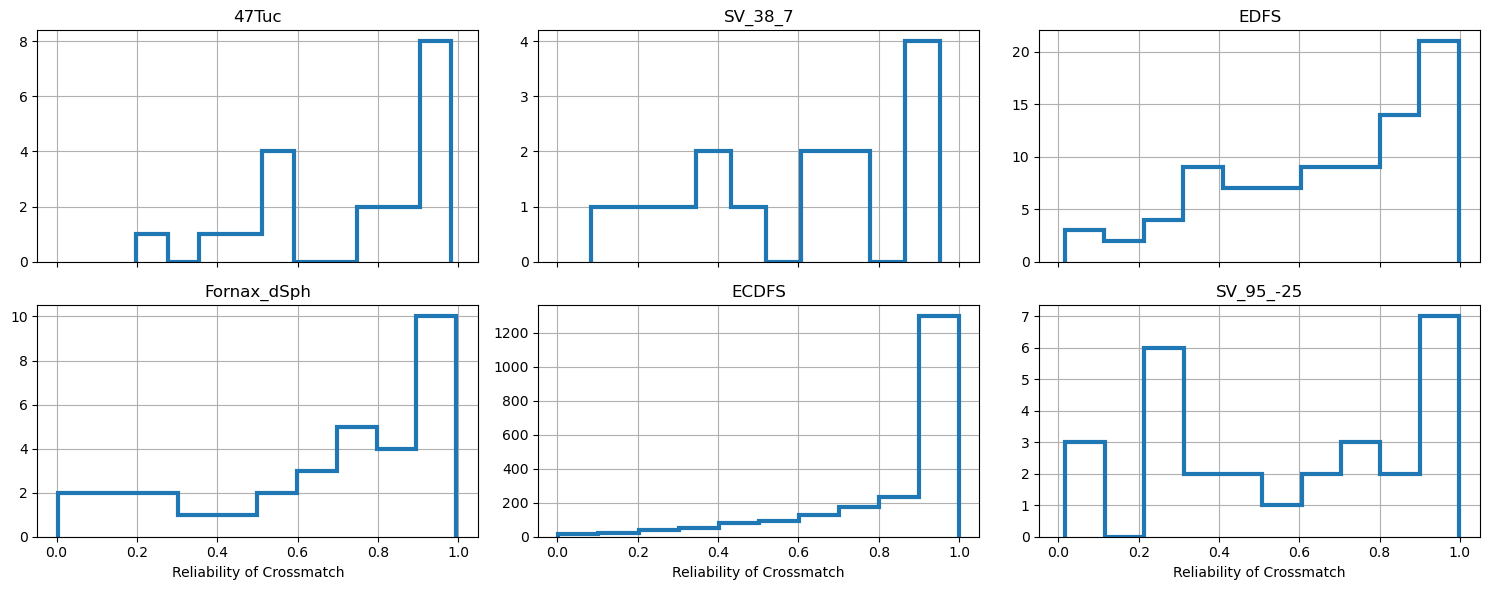

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15,6))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']):
    row = i%2
    col = i%3
    sub = obj_closest.query(f'field_X == "{field}"')['reliability']
    sub.hist(ax=axs[row,col], histtype='step', linewidth=3)
    axs[row,col].set_title(field)
    if row == 1:
        axs[row,col].set_xlabel('Reliability of Crossmatch')
plt.tight_layout()

In [57]:
obj.to_parquet('../../data/final_data_products/obj_dp1_xmatch_added.parquet')

In [58]:
obj_closest.to_parquet('../../data/final_data_products/obj_dp1_xmatch_closest.parquet')

## Define a "reliable sample" where reliability > .9

In [59]:
reliable = obj_closest[obj_closest['reliability'] > .9]
reliable.to_parquet('../../data/final_data_products/obj_dp1_xmatch_added_reliable.parquet')

### KS test on mag bins

To test whether the matched objects are more variable than a random set of field objects, we compare the Stetson Js for the random set of crossmatches to the stetsonJs from the matches

<Axes: >

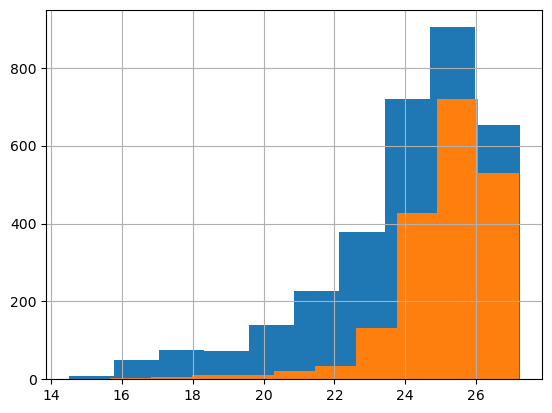

In [60]:
from scipy.stats import ks_2samp

obj[(obj['g_psfFlux'] / obj['g_psfFluxErr']) > 5 ]['g_psfMag'].hist()
obj_random[(obj_random['g_psfFlux'] / obj_random['g_psfFluxErr']) > 5 ]['g_psfMag'].hist()


In [61]:
print(len(obj[(obj['g_psfFlux'] / obj['g_psfFluxErr']) > 5 ]['g_psfMag']), len(obj_random[(obj_random['g_psfFlux'] / obj_random['g_psfFluxErr']) > 5 ]['g_psfMag']))

3225 1892


17_19:   g


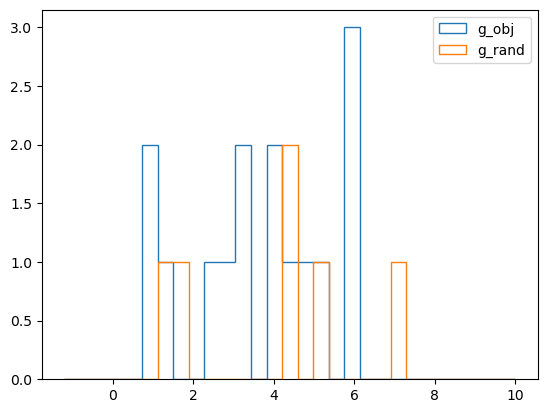

17_19:   r


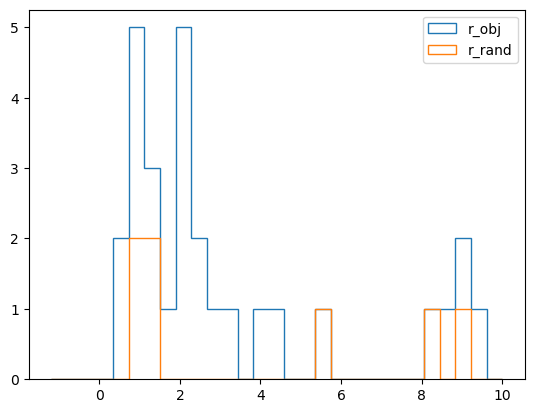

17_19:   i


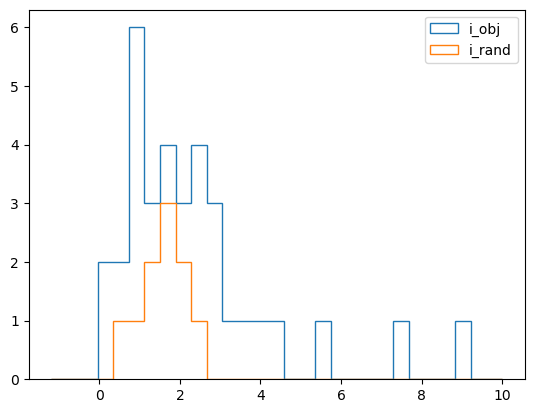

19_21:   g


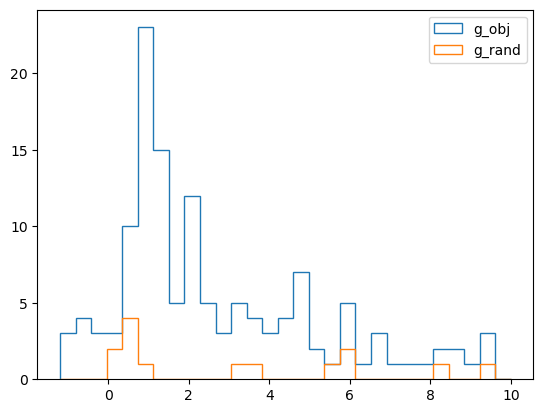

19_21:   r


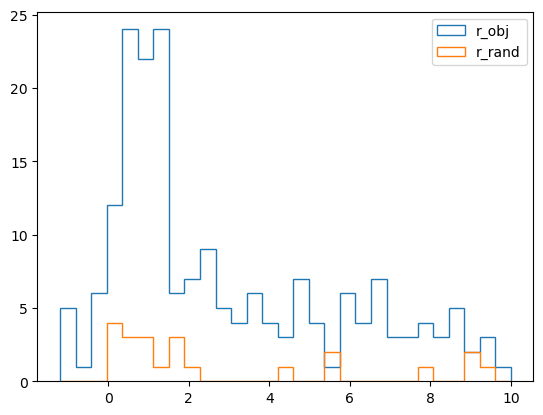

19_21:   i


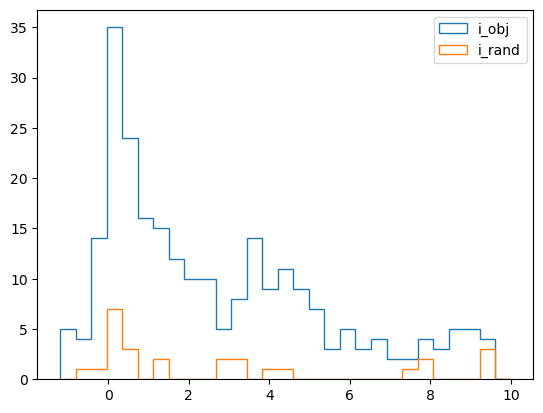

21_23:   g


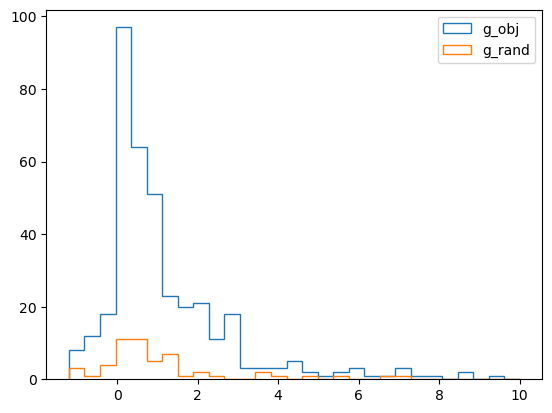

21_23:   r


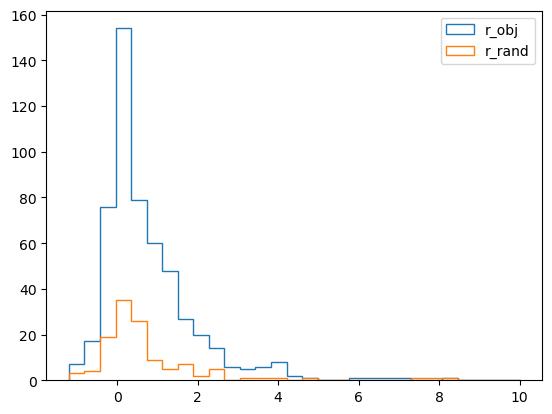

21_23:   i


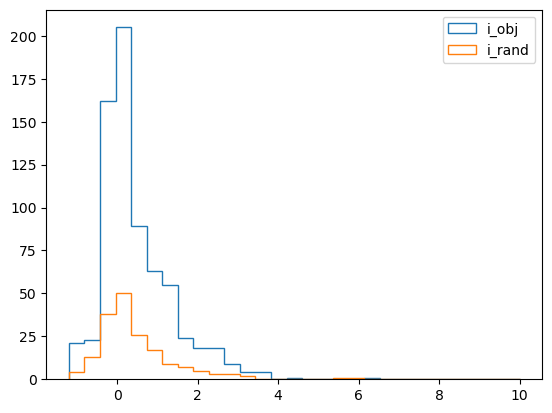

23_25:   g


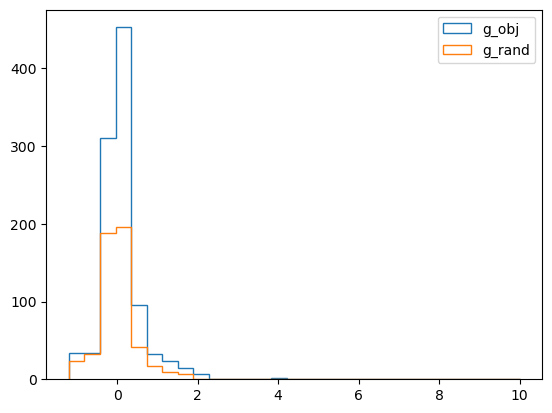

23_25:   r


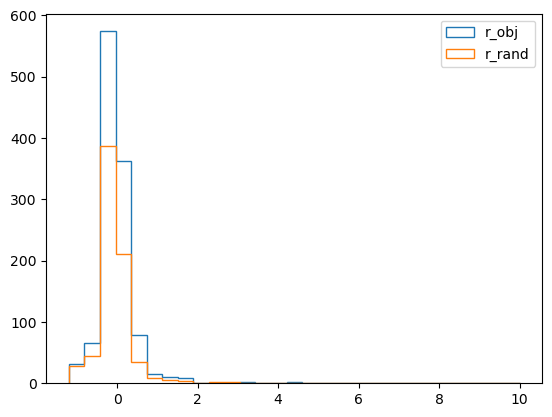

23_25:   i


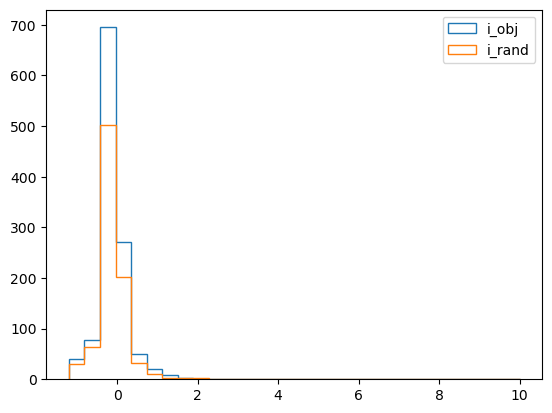

In [62]:
mag_bins = np.arange(17, 27, 2)
mag_lower = mag_bins[:-1]
mag_upper = mag_bins[1:]
results = {}

for i in range(len(mag_lower)):
    res_mag = {}
    lb = mag_lower[i]
    ub = mag_upper[i]
    for band in 'gri':
        sub_obj = obj[(obj[f'{band}_psfMag'] > lb) & (obj[f'{band}_psfMag'] < ub)]
        
        sub_rand = obj_random[(obj_random[f'{band}_psfMag'] > lb) & (obj_random[f'{band}_psfMag'] < ub)]


        if (len(sub_obj) <= 20) | (len(sub_rand) <=20):
            res_mag[band] = np.nan
        # sub_rand = obj_control[(obj_control[f'{band}_psfMag'] > lb) & (obj_control[f'{band}_psfMag'] < ub)]
        
        samp1 = sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna()
        samp2 = sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna()
        res = ks_2samp(sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna(), sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna(), alternative='less')
        res_mag[band] = round(res.pvalue, 3)

        print(f'{lb}_{ub}:  ',band)
        plt.hist(sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna(), bins=np.linspace(-1.2, 10, 30), histtype='step', label=band+'_obj')
        plt.hist(sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna(), bins=np.linspace(-1.2, 10, 30), histtype='step', label=band+'_rand')
        # plt.xscale('log')
        plt.legend()
        plt.show()
        
        
    results[f'{lb}_{ub}'] = res_mag

In [63]:
results

{'17_19': {'g': np.float64(0.066),
  'r': np.float64(0.07),
  'i': np.float64(0.012)},
 '19_21': {'g': np.float64(0.14),
  'r': np.float64(0.266),
  'i': np.float64(0.211)},
 '21_23': {'g': np.float64(0.488),
  'r': np.float64(0.206),
  'i': np.float64(0.113)},
 '23_25': {'g': np.float64(0.001),
  'r': np.float64(0.002),
  'i': np.float64(0.038)}}

### KS Test between reliable and not reliable sources (revision)

In [64]:
unreliable = obj_closest[~obj_closest['objectId'].isin(reliable['objectId'])]

17_19:   g


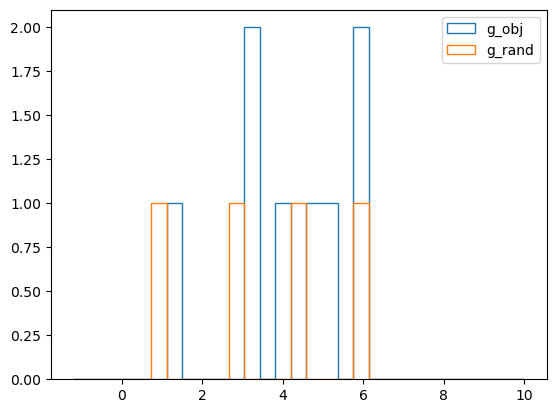

17_19:   r


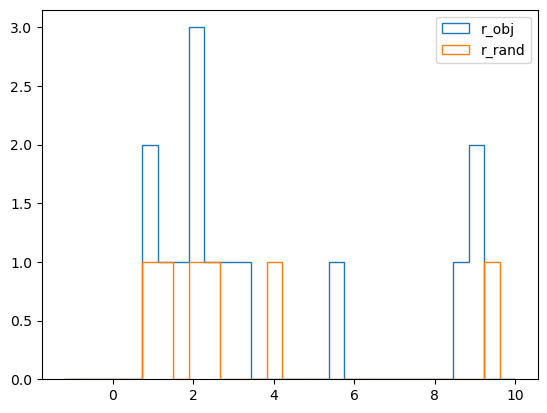

17_19:   i


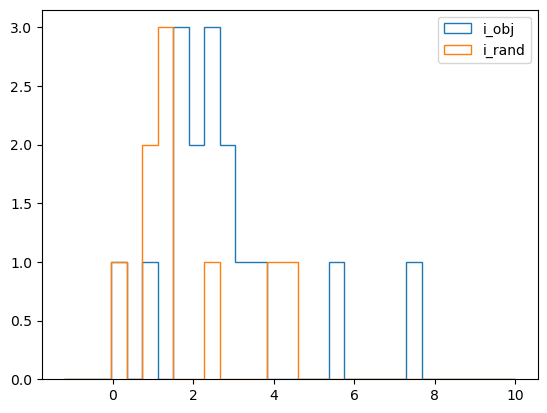

19_21:   g


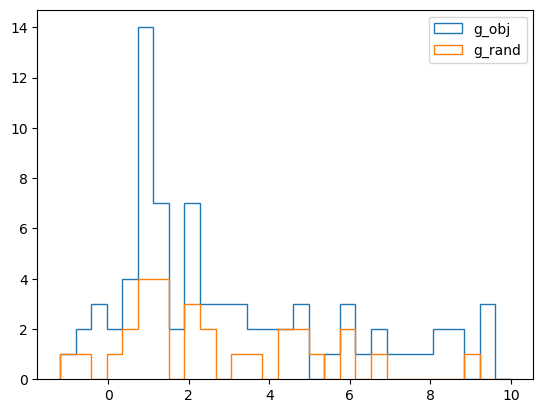

19_21:   r


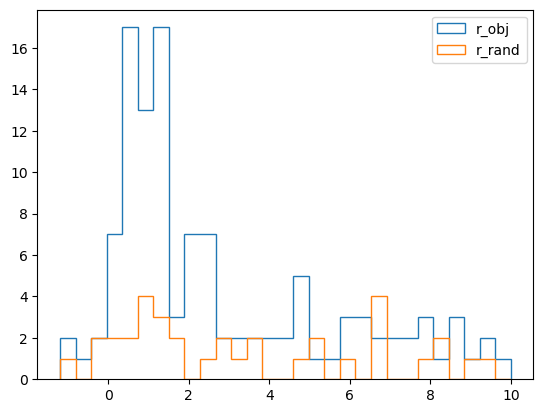

19_21:   i


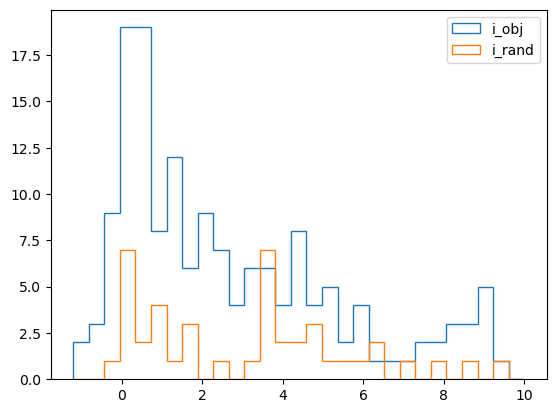

21_23:   g


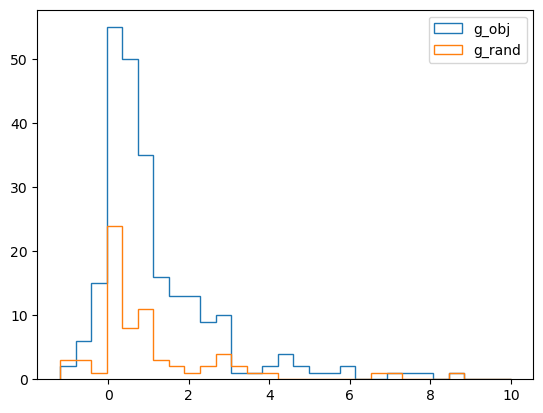

21_23:   r


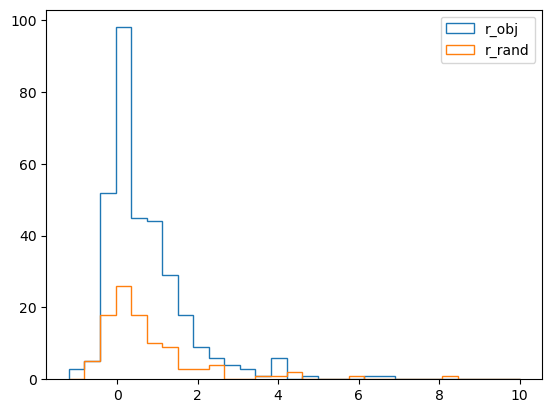

21_23:   i


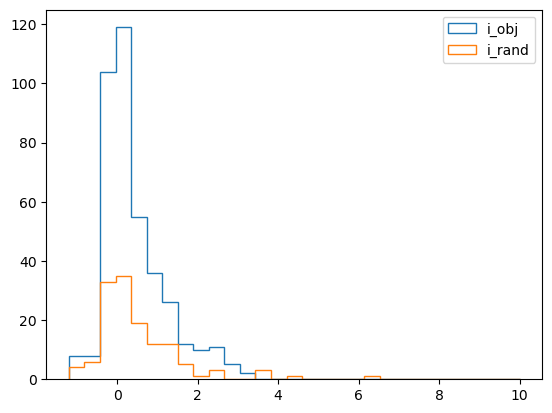

23_25:   g


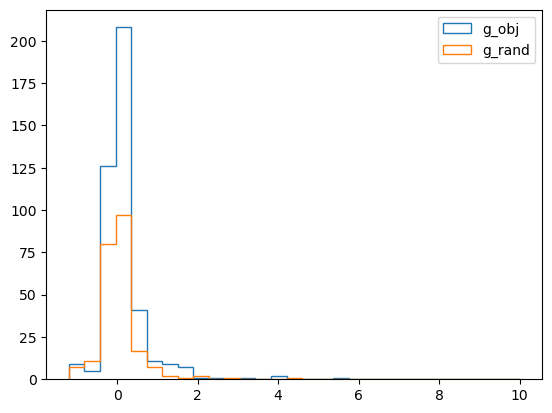

23_25:   r


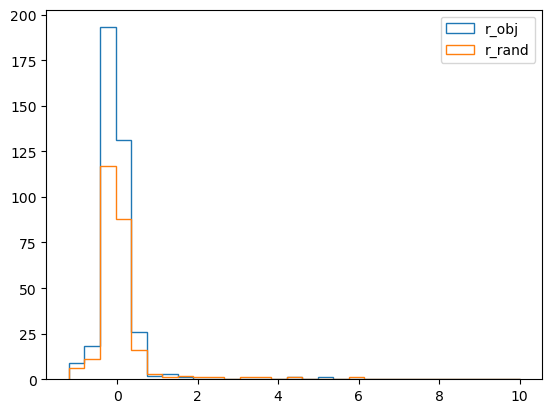

23_25:   i


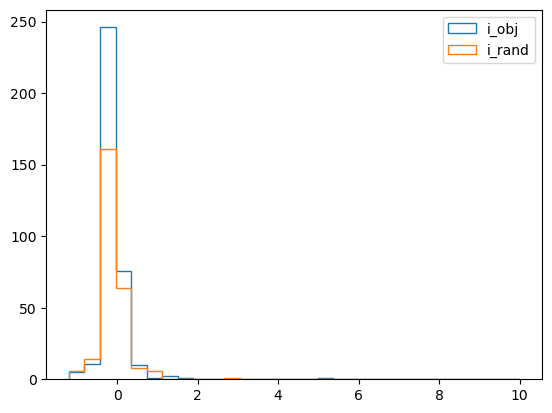

In [65]:
mag_bins = np.arange(17, 27, 2)
mag_lower = mag_bins[:-1]
mag_upper = mag_bins[1:]
results = {}

for i in range(len(mag_lower)):
    res_mag = {}
    lb = mag_lower[i]
    ub = mag_upper[i]
    for band in 'gri':
        sub_obj = reliable[(reliable[f'{band}_psfMag'] > lb) & (reliable[f'{band}_psfMag'] < ub)]
        
        sub_rand = unreliable[(unreliable[f'{band}_psfMag'] > lb) & (unreliable[f'{band}_psfMag'] < ub)]


        if (len(sub_obj) <= 20) | (len(sub_rand) <=20):
            res_mag[band] = np.nan
        # sub_rand = obj_control[(obj_control[f'{band}_psfMag'] > lb) & (obj_control[f'{band}_psfMag'] < ub)]
        
        samp1 = sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna()
        samp2 = sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna()
        res = ks_2samp(sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna(), sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna(), alternative='less')
        res_mag[band] = round(res.pvalue, 3)

        print(f'{lb}_{ub}:  ',band)
        plt.hist(sub_obj[f'{band}_psfFluxForcedStetsonJ'].dropna(), bins=np.linspace(-1.2, 10, 30), histtype='step', label=band+'_obj')
        plt.hist(sub_rand[f'{band}_psfFluxForcedStetsonJ'].dropna(), bins=np.linspace(-1.2, 10, 30), histtype='step', label=band+'_rand')
        # plt.xscale('log')
        plt.legend()
        plt.show()
        
        
    results[f'{lb}_{ub}'] = res_mag

In [66]:
results

{'17_19': {'g': np.float64(0.231),
  'r': np.float64(0.448),
  'i': np.float64(0.043)},
 '19_21': {'g': np.float64(0.419),
  'r': np.float64(0.771),
  'i': np.float64(0.779)},
 '21_23': {'g': np.float64(0.175),
  'r': np.float64(0.612),
  'i': np.float64(0.374)},
 '23_25': {'g': np.float64(0.002),
  'r': np.float64(0.549),
  'i': np.float64(0.51)}}